# Week 9 Assignment

## Deep Learning Continued

In this assignment you will be a pixel-based neural network for landcover (multi-class) classification as well as learn how to expand your neural network modeling skills into the spatial realm with convolutional nueral networks (chip based method) and how you can apply convolutional neural networks to pixel classification tasks (semantic segmentation)

__Raster Files__: 

    - Landsat.tif (remotely sensed data in the form of surface reflactance, will be used as the input to our models) [values (0 - 10000)] numerical
    - Impervious.tif (NLCD fractional impervious map, will be used as our "ground truth" in training some of our modes) [values (0 - 100)] numerical
    - Dem.tif (ancillary data in the form of elevation data) [values (0 - 10000)] numerical
    - Aspect.tif (ancillary data in the form of downslope direction) [values (0 - 8)] categorical
    - Posidex.tif (ancially date in the form of positional index) [values (0 - 100)] numerical
    - Wetlands.tif (ancillary data in the form of wetlands information) [values (0 - 17)] categorical

## 1. Import the required libraries

> __HINT__: Find the libraries you need to import in the assignment instructions

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from functions import one_hot_encode

## 1a. Import your multi-class classification preprocessing function

> HINT: See instructions for example function if you do not have one written

In [9]:
def multiclass_classification_preprocess(dataframe):
    # subset dataframe
    subset = dataframe.loc[((dataframe['landcover_1'] > 0) & (dataframe['landcover_1'] <= 95))]
    # reset index
    subset = subset.reset_index(drop=True)
    # fill invalid values
    subset['dem_1'] = subset['dem_1'].replace(-9999, subset['dem_1'].mean())
    subset['aspect_1'] = subset['aspect_1'].replace(255, 18)
    subset['wetlands_1'] = subset['wetlands_1'].replace(-1, 0)
    subset['posidex_1'] = subset['posidex_1'].replace(-1, 0)
    # one hot encode categorical features
    subset = one_hot_encode(subset, "aspect_1")
    subset = one_hot_encode(subset, "wetlands_1")
    # return transformed dataframe
    return subset

## 1b. Load in dataset

In [10]:
dataset = pd.read_csv('geoKARMA_h24v13_pixelbased_dataset.csv')

## 1c. Expand this function to create a nn_multiclass_classification_preprocessing function that scales all continous values to 0-1

> HINT: Neural Networks expect normalized data, if you know a global scaling value, scale by that, if not just perform z-score scaling

In [11]:
def nn_multiclass_classification_preprocessing(dataframe):
    df = multiclass_classification_preprocess(dataframe)
    df['dem_1'] = df['dem_1'] / 10000
    df['posidex_1'] = df['posidex_1'] / 100
    df['NDVI'] = (df['landsat_4'] - df['landsat_3']) / (df['landsat_4'] + df['landsat_3'])
    df[['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']] = df[['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']] / 10000
    df.fillna(0)
    return df

In [12]:
dataframe = nn_multiclass_classification_preprocessing(dataset)
dataframe.fillna(0, inplace=True)
dataframe.isnull().sum()

landsat_1        0
landsat_2        0
landsat_3        0
landsat_4        0
landsat_5        0
landsat_6        0
dem_1            0
posidex_1        0
landcover_1      0
impervious_1     0
urban_count_7    0
urban_count_5    0
urban_count_3    0
xgeo             0
ygeo             0
aspect_1_0       0
aspect_1_1       0
aspect_1_2       0
aspect_1_3       0
aspect_1_4       0
aspect_1_5       0
aspect_1_6       0
aspect_1_7       0
aspect_1_8       0
aspect_1_9       0
aspect_1_10      0
aspect_1_11      0
aspect_1_12      0
aspect_1_13      0
aspect_1_14      0
aspect_1_15      0
aspect_1_16      0
aspect_1_17      0
aspect_1_18      0
wetlands_1_0     0
wetlands_1_2     0
wetlands_1_3     0
wetlands_1_4     0
wetlands_1_5     0
wetlands_1_6     0
wetlands_1_7     0
wetlands_1_8     0
NDVI             0
dtype: int64

## 1d. Print Dataset columns

In [13]:
dataframe.columns
dataframe.isnull().sum()

landsat_1        0
landsat_2        0
landsat_3        0
landsat_4        0
landsat_5        0
landsat_6        0
dem_1            0
posidex_1        0
landcover_1      0
impervious_1     0
urban_count_7    0
urban_count_5    0
urban_count_3    0
xgeo             0
ygeo             0
aspect_1_0       0
aspect_1_1       0
aspect_1_2       0
aspect_1_3       0
aspect_1_4       0
aspect_1_5       0
aspect_1_6       0
aspect_1_7       0
aspect_1_8       0
aspect_1_9       0
aspect_1_10      0
aspect_1_11      0
aspect_1_12      0
aspect_1_13      0
aspect_1_14      0
aspect_1_15      0
aspect_1_16      0
aspect_1_17      0
aspect_1_18      0
wetlands_1_0     0
wetlands_1_2     0
wetlands_1_3     0
wetlands_1_4     0
wetlands_1_5     0
wetlands_1_6     0
wetlands_1_7     0
wetlands_1_8     0
NDVI             0
dtype: int64

# 2. Feature Selection

In [14]:
target = 'landcover_1'
features = [
    'landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
    'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
    'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
    'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
    'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
    'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
    'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
    'dem_1', 'posidex_1', 'NDVI'
]

#### 2a. Assign the target and feature variables
> Assign “landcover_1” as the target variable called __target__ and __features__ = ['landsat_{i}', 'dem_1', 'posidex_1', 'aspect_1_{i}', 'wetlands_1_{i}'] 

> __RECAP__: __Target variable__ is the dependent variable. That is, the variable whose value we want to predict.

> __Feature variable__ is the independent variable ie the variables which are used to predict the value of the dependent variable


In [15]:
X = dataframe[features]
y = dataframe[target]

## 2a. Print unique values in y

> HINT: np.unique()

In [16]:
y.unique()

array([42, 41, 81, 21, 24, 43, 23, 22, 11, 90, 71, 52, 31, 82, 95],
      dtype=int64)

## 3. Label Encoding

> __NOTE__: NLCD class legend is as follows (see image below)

<img src="nlcd_landcover_legend.jpg" alt="Drawing" style="width: 300px;"/>

> We need to remap these values to be between 0-num_classes


In label encoding, each label is assigned a unique integer. This is based on alphabetical ordering. For example, if you were to encode Apple, Strawberry and Orange, Apple would be assigned the value 0, Orange: 1, and Strawberry: 2

you can use packaged solutions to this problem or create your own solution like below https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [17]:
label_encoding = {11: 0, 12:1, 21: 2, 22: 3, 23: 4, 24: 5, 31: 6, 41: 7, 42: 8,
                  43: 9, 52: 10, 71: 11, 81: 12, 82: 13, 90: 14, 95: 15}

def remap(value: int, encoding: dict) -> int:
    return encoding[value]

# Encode labels in column 'landcover_1'
y = np.vectorize(lambda x: label_encoding[int(x)])(y)

## 3a. Print unique values in encoded y

In [18]:
np.unique(y)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

## 3b. Sparse categorical crossentropy vs categorical crossentropy

https://www.tensorflow.org/api_docs/python/tf/keras/metrics/categorical_crossentropy

https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy

Categorical crossentropy expects a vector of one-hot encoded labels where as sparse categorical crossentropy expects a vector of 0-num_classes labels.
So, if we want to use the y vector as is, we would need to use sparse categorical crossentropy. If we want to use categorical crossentropy, we would need to one-hot encode the labels.



## 3c. One-hot encode the target vector

> HINT: from tensorflow.keras.utils import to_categorical, num_classes=len(label_encoding.keys())

https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [19]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, num_classes = len(label_encoding.keys()))

## 3d. Print X, y shapes for model inputs

In [20]:
print(X.shape)
print(y.shape)

(474950, 36)
(474950, 16)


## 3e. Train Test Split

In [21]:
#splitting the data into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=1)

## 4. Building the Model

> NOTE: Here we are building a pixel-based neural network, the last dense layer outputs to the number of classes we have and since this is a multi-class classification problem, the final activation function is softmax

In [22]:
# functional
def dense_block(x, nlayers, dropout=0, batch_norm=False):
    
    x = tf.keras.layers.Dense(nlayers, activation='relu')(x)
    if dropout > 0:
        x = tf.keras.layers.Dropout(dropout)(x)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    return x

def DNN_functional(shape, out_dim, activ, norm=False):

    inputs = tf.keras.layers.Input(shape) 

    x = dense_block(inputs, 64, 0, norm)
    x = dense_block(x, 128, 0, norm)
    x = dense_block(x, 1024, 0.5, norm)
    x = dense_block(x, 256, 0.2, norm)
    output = tf.keras.layers.Dense(out_dim, activation=activ)(x)
            
    return tf.keras.Model(inputs=inputs, outputs=output, name='DNN')

## 4a. Create Model variable and Print the model summary

In [23]:
model = DNN_functional(36, len(label_encoding.keys()), 'softmax', True)

In [24]:
model.summary()

Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense (Dense)               (None, 64)                2368      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1024)              132096  

# 5. Training The Neural Network

https://www.tensorflow.org/guide/keras/training_with_built_in_methods

> Steps to Follow:

> - Wrangle Training / Validation data
> - Preprocess Data for Neural Network

> __NOTE__: Input data needs to be either between [-1, 1], or [0, 1] for neural networks, so categorical data must be one-hot encoded, continues data normalized

> - Build Network
> - Compile Network with specified hyperparameters
> - Train the Network
> - Evaluate
> - Iterate

> NOTE: if you haven't yet, add the run_training, and compile_model functions from week 8 to your functions.py file so you can just import them here

In [25]:
def get_compiled_model(model, opt, loss, metric):
    print("Compiling and returning model")
    model.summary()
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[metric]
        )
    return model

def run_training(model, tdataset, vdataset, 
                 epochs, batch_size, opt, loss, metric):
    
    model = get_compiled_model(model, opt, loss, metric)
    print("Setting Callbacks")
    model_output = tf.keras.callbacks.ModelCheckpoint(f"model.h5", monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False)    
    print(f"Training model")
    return model.fit(
        tdataset[0],
        tdataset[1],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(vdataset[0], vdataset[1]),
        callbacks=[model_output]
        )

## 5a. Call the training function and train your model

In [26]:
history = run_training(model, (X_train, y_train), (X_test, y_test), 10, 1024, tf.keras.optimizers.Adam(learning_rate=1e-2), 'categorical_crossentropy', 'categorical_accuracy')

Compiling and returning model
Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense (Dense)               (None, 64)                2368      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (Non

Epoch 1/10
140/140 [==============================] - 37s 234ms/step - loss: 1.3612 - categorical_accuracy: 0.5501 - val_loss: 2.0291 - val_categorical_accuracy: 0.4033


c:\Users\dorothy\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
140/140 [==============================] - 32s 229ms/step - loss: 1.1988 - categorical_accuracy: 0.5898 - val_loss: 1.4031 - val_categorical_accuracy: 0.5261
Epoch 3/10
140/140 [==============================] - 37s 264ms/step - loss: 1.1697 - categorical_accuracy: 0.5961 - val_loss: 1.2520 - val_categorical_accuracy: 0.5736
Epoch 4/10
140/140 [==============================] - 35s 254ms/step - loss: 1.1449 - categorical_accuracy: 0.6019 - val_loss: 1.2447 - val_categorical_accuracy: 0.5718
Epoch 5/10
140/140 [==============================] - 37s 268ms/step - loss: 1.1205 - categorical_accuracy: 0.6096 - val_loss: 1.3027 - val_categorical_accuracy: 0.5531
Epoch 6/10
140/140 [==============================] - 37s 265ms/step - loss: 1.1099 - categorical_accuracy: 0.6112 - val_loss: 1.2168 - val_categorical_accuracy: 0.5843
Epoch 7/10
140/140 [==============================] - 39s 280ms/step - loss: 1.1018 - categorical_accuracy: 0.6144 - val_loss: 1.1488 - val_categorical_acc

## 5b. Convert the history.history dictionary to a dataframe called "learning history" and print the dataframe

In [34]:
learning_history = pd.DataFrame(history.history)
learning_history

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,1.361151,0.550093,2.029141,0.403306
1,1.198823,0.589767,1.403073,0.526101
2,1.169704,0.596119,1.251981,0.573591
3,1.144901,0.601895,1.244729,0.571808
4,1.120461,0.609629,1.302677,0.553126
5,1.109897,0.611201,1.216766,0.584290
6,1.101834,0.614402,1.148756,0.596348
7,1.097264,0.615721,1.134540,0.603456
8,1.091333,0.618044,1.381371,0.545447
9,1.086712,0.618198,1.161790,0.597774


## 4c. Print a line plot that shows the categorical_accuracy and val_categorical_accuracy
> With the help of this plot, you can see how the accuracy increases with the increase in number of epochs

> HINT: You can find the code in the assignment instructions

<Axes: >

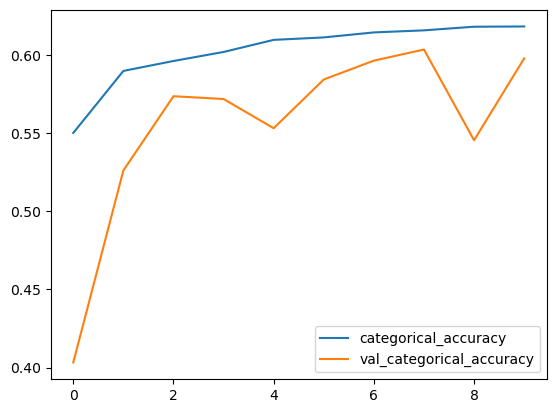

In [35]:
learning_history.plot(kind='line', y=['categorical_accuracy', 'val_categorical_accuracy'])

## 6. Evaluate the Model

### 6a. Load in Checkpoint Model

> HINT: Look at instructions for code to load the model in

In [36]:
model = tf.keras.models.load_model("model.h5", compile=False)

### 6b. Predict the observations for train and test sets and assign the values to X_train_pred and X_test_pred respectively and print the two variables shapes (X_train_pred and X_test_pred)

How did this iteration of the model perform?

Try adding in more hidden layers, increasing the number of nodes in each hidden layer, trying different activation functions, etc. 

Do some hyperparameter tuning and see if you can create a model that performs even better

In [37]:
X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

10390/10390 [==============================] - 67s 6ms/step


In [38]:
print('X_train_pred= ', X_train_pred.shape)
print('X_test_pred= ', X_test_pred.shape)

X_train_pred=  (142485, 16)
X_test_pred=  (332465, 16)


#### 5b. Return indices of the maximum values in X_train_pred and X_test_pred and assign them to variables tr_max_indices and te_max_indices respectively

> NOTE: these are softmax outputs, this means we need to take the argmax to determine which calss the maximum prediction belongs to

> HINT: np.argmax(, axis=softmax_axis)

In [41]:
tr_max_indices = np.argmax(X_train_pred, axis=-1)
te_max_indices = np.argmax(X_test_pred, axis=-1)
tr_max_indices,  te_max_indices


(array([7, 7, 5, ..., 2, 7, 7], dtype=int64),
 array([ 7,  2,  8, ...,  3, 12,  2], dtype=int64))

#### 5c. Return indices of the maximum values in y_train and y_test and assign them to variables ytr_max_indices and yte_max_indices respectively

> NOTE: these are softmax outputs, this means we need to take the argmax to determine which calss the maximum prediction belongs to

> HINT: np.argmax(, axis=softmax_axis)

In [43]:
ytr_max_indices = np.argmax(y_train, axis=-1)
yte_max_indices = np.argmax(y_test, axis=-1)
ytr_max_indices, yte_max_indices

(array([ 7,  2,  5, ...,  3, 12,  7], dtype=int64),
 array([14,  7,  8, ...,  3, 12,  8], dtype=int64))

## 6b. Print the accuracy, F1 score and classification report for the train set
> HINT: You can find the code in the assignment instructions

In [50]:
print("Accuracy score = ", accuracy_score(ytr_max_indices, tr_max_indices))
print("F1 score = ", f1_score(ytr_max_indices, tr_max_indices, average=None))
print("Classification report = ", classification_report(ytr_max_indices, tr_max_indices))

Accuracy score =  0.6062462715373548
F1 score =  [0.91935484 0.33226415 0.50473112 0.50692942 0.68200947 0.
 0.75355178 0.65086193 0.2169462  0.         0.04059376 0.70304936
 0.         0.81500481 0.11904762]


c:\Users\dorothy\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report =                precision    recall  f1-score   support

           0       0.90      0.94      0.92      3044
           2       0.35      0.32      0.33     16661
           3       0.48      0.53      0.50     12215
           4       0.50      0.51      0.51      6214
           5       0.55      0.89      0.68      2915
           6       0.00      0.00      0.00       438
           7       0.68      0.85      0.75     40935
           8       0.74      0.58      0.65     17075
           9       0.41      0.15      0.22     13470
          10       0.00      0.00      0.00      2154
          11       0.46      0.02      0.04      3154
          12       0.62      0.81      0.70     20581
          13       0.00      0.00      0.00       231
          14       0.85      0.78      0.82      3242
          15       0.83      0.06      0.12       156

    accuracy                           0.61    142485
   macro avg       0.49      0.43      0.42    142485
w

c:\Users\dorothy\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dorothy\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Part 2: Chip Based Method (CNN -> Unet)

## 1. Data Sampling

### 1a. Pixel-based

Up until this point we have been using point based methods, methods where we sample individual points of data. Below you can see a visual representation of this with the green dots being the training points and the red dots being the validation (test) points. 

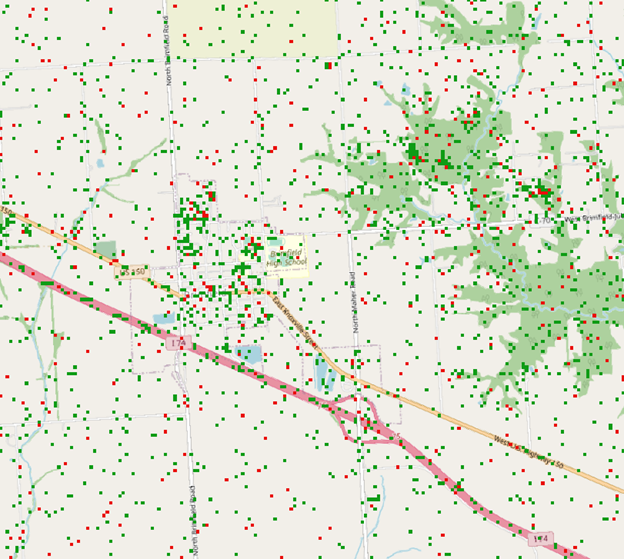

Also, it is important to note that these point based methods result in 2 dimensional data. Let's take a look at the shape of our training dataset to see what this looks like.

> NOTE: the shape represents (samples, features)

In [51]:
X_train.shape

(142485, 36)

### 1b. Chip Based

Here you can see we are now sampling chips of data of ROIs (regions of interest). The green here are also training and the red validation (test). When creating this chips of data, you want to create them with the same number of rows and number of columns and you also want to make sure the number you chose is a multiple of 2. This is because the Unet convolutional neural network essentially performs down and upsampling while processing the layers and it expects chips such as (512 X 512), (256 X 256), (128 X 128), etc.

> NOTE: chosing you chip size is a hyperparameter of your system and can make some difference. For geospatial data, I like to keep in mind that the model should have access to some global context when making local decisions, but not too much context. Therefore, we need to take into consideration the resolution of the imagery (how many meters are represented by one pixel) when determining our chip size. I have had good luck with 256 X 256 for building Unets for Landsat Imagery with a 30m resolution.


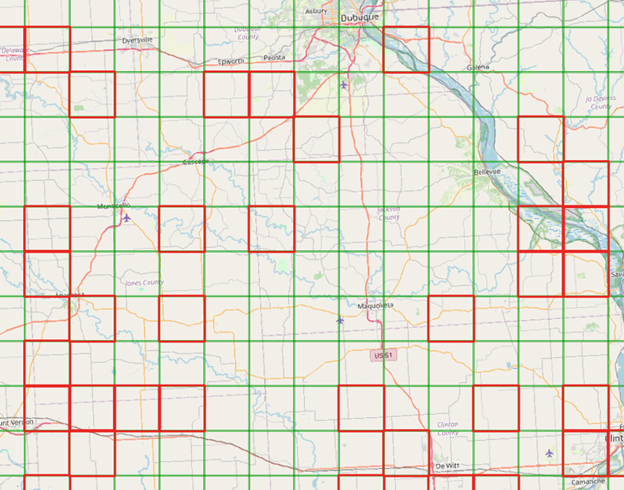

Let's take a look at what the dataset might look like for chip-based data. Let's load in a couple chips of our landsat data using the function below

In [52]:
import rasterio as rio

def read_image(path: str, xgeo: int, ygeo: int, ncols: int, nrows: int) -> np.ndarray:
    """
    Read raster window into numpy array.
    """
    with rio.open(path) as ds:
        row, col = ds.index(xgeo, ygeo)
        data = ds.read(
            window=rio.windows.Window(col, row, ncols, nrows)
            )
        data[data == ds.nodata] = 0
    return data.squeeze()

In [55]:
paths = {
    "landsat": './data/geoKARMA_h24v13_landsat_2019.tif', # pure raw data from sattelite
    "landcover": './data/geoKARMA_h24v13_landcover_2019.tif' # modeled / mapped (classification)
}
coords = [
    (1034416, 1364804),
    (1042095, 1357125)
]

> NOTICE: If we generate an array of samples with a single channel raster, in this case the "landcover" raster we end up with a 3 dimensional array. the output being (samples, height, width).


In [56]:
np.array([read_image(paths['landcover'], *coord, 256, 256) for coord in coords]).shape

(2, 256, 256)

> NOTICE: Now, if we read in a multi channel raster like the "landsat" raster we get a 4 dimensional data set, the output being (samples, channels, height, width)

In [57]:
np.array([read_image(paths['landsat'], *coord, 256, 256) for coord in coords]).shape

(2, 6, 256, 256)

> NOTE: Tensorflow is in "channels last" mode by default. This means it expects the inputs to be (samples, height, width, channels) so we will have to move the axis of these data to be in the proper orientation

> IMPORTANT: When creating your datasets, if you need to transpose your input imagery make sure to also transpose your target masks so that they line up with each other. Us matplotlib to visualize things to ensure everything is lining up properly before scaling up

> NOTE: Pytorch is in "channel first" mode by default. So, no transposition is required

In [58]:
np.array([read_image(paths['landsat'], *coord, 256, 256).transpose() for coord in coords]).shape # channels last make sure to orient the mask as well when reading this into datasets

(2, 256, 256, 6)

In [59]:
import matplotlib.pyplot as plt

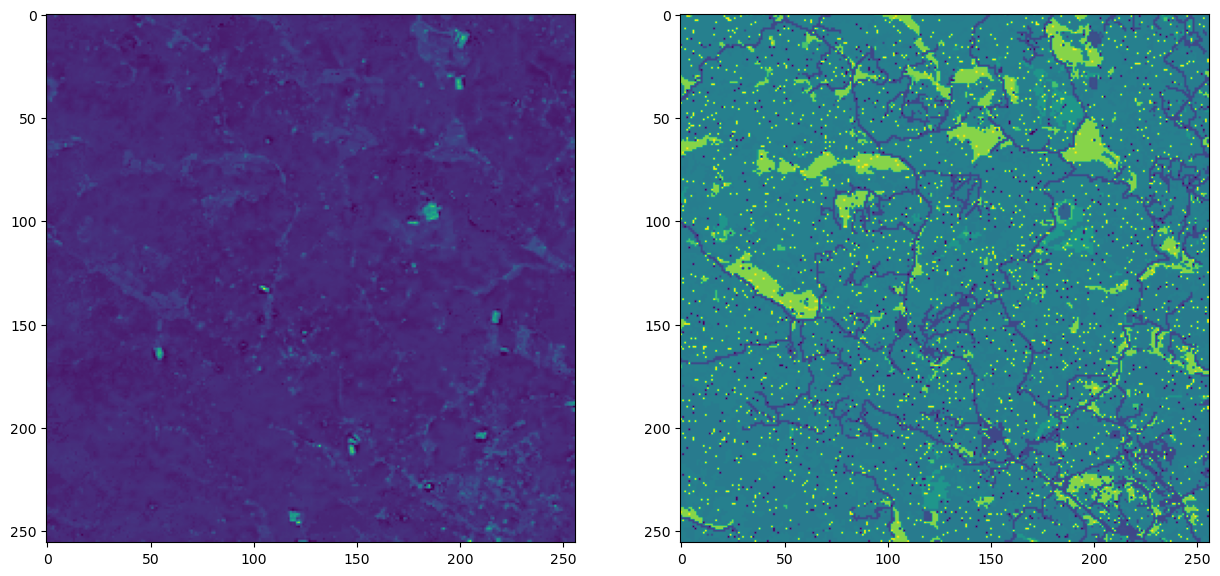

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
ax[0].imshow(np.array([read_image(paths['landsat'], *coord, 256, 256).transpose() for coord in coords])[0, :, :, 0])
ax[1].imshow(np.array([read_image(paths['landcover'], *coord, 256, 256).transpose() for coord in coords])[0, :, :])

## 2. Batch Loading

When you start to move into larger datasets you're not going to be able to load everything into memory all at once like we have been. You will have to start performing batch loading and batch processing which is where using tenforflow td.data.Dataset pipelines and pytorch dataloaders start to come in handy. One approach is to create a csv of ROI information that acts as the "dataset" then when you need a batch of actual raster data, you define a dataset loading function that takes the batch of ROI information and reads those data chips into memory for computation.

### 2a. Creating CSV of ROI information

In [61]:
def generate_chips(paths, bounds, chip=256, gsd=30):
    """
    Generates grid of chips for training data
    """
    total_chunks = []
    for xgeo in np.arange(bounds.left, bounds.right, gsd*chip):
        for ygeo in np.arange(bounds.top, bounds.bottom, -gsd*chip):
            total_chunks.append({"img_path": paths['image'], "mask_path": paths['mask'], "xgeo": xgeo, "ygeo": ygeo})
    return pd.DataFrame(total_chunks) 

## 2b. Create Batch Dataset Loading Functions Tensorflow


Here we are just defining the data pipeline functions that take as input the csv file we created above that holds our image paths as well as our chip geographic information

Here are the docs on more details of how tf.data.Dataset works and how you can customize it to your needs https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [62]:
import rasterio as rio
from typing import Tuple
from functools import partial
from tensorflow.keras.utils import to_categorical

def load_image(config: dict, train: bool = True):
    """
    Load csv data into list of paths and coordinates.
    """
    if train:
        file = config['train_rois']
    else:
        file = config['val_rois']
    df = pd.read_csv(file)
    img_samples = [np.array([df.iloc[i]['img_path'], df.iloc[i]['xgeo'], df.iloc[i]['ygeo']]) for i in range(len(df))]
    mask_samples = [np.array([df.iloc[i]['mask_path'], df.iloc[i]['xgeo'], df.iloc[i]['ygeo']]) for i in range(len(df))]

    return img_samples, mask_samples

def scale_raster(array: np.ndarray, collection: str) -> np.ndarray:
    """
    Apply proper scaling for either collection-1 or collection-2 Landsat data
    """
    if collection == 'collection-1':
        return array * 0.0001
    elif collection == 'collection-2':
        return (array * 0.0000275) - 0.2
    
def read_image(path: str, xgeo: int, ygeo: int, ncols: int, nrows: int) -> np.ndarray:
    """
    Read raster window into numpy array.
    """
    with rio.open(path) as ds:
        row, col = ds.index(xgeo, ygeo)
        data = ds.read(
            window=rio.windows.Window(col, row, ncols, nrows)
            )
        data[data == ds.nodata] = 0
    return data.squeeze()

def transform_image(path: str, xgeo: int, ygeo: int, size: int, collection: str) -> np.ndarray:
    """
    Read raster data chip into numpy array and normalize.
    """
    array = read_image(path, xgeo, ygeo, size, size).transpose() # for tensorflow
    return scale_raster(array, collection).astype(np.float32) # applying scaling factor

def transform_mask(path: str, xgeo: int, ygeo: int, size: int,) -> np.ndarray:
    """
    Convert NLCD target mask into 0-nclasses.
    """
    classes = [0, 11, 12, 21, 22, 31, 41, 42, 43, 45, 46, 52, 71, 81, 82, 90, 95] 
    convert_map = {val:ind for ind, val in enumerate(classes)}
    mask = read_image(path, xgeo, ygeo, size, size).transpose()
    return to_categorical(np.vectorize(lambda x: convert_map[int(x)])(mask), len(classes))

def preprocess(image: np.array, mask: np.array, config: dict) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Landcover preprocessing function.
    """
    def f(image=image, mask=mask):
        image = transform_image(image[0].decode('utf-8'), image[1], image[2], config['size'], config['collection'])
        mask = transform_mask(mask[0].decode('utf-8'), mask[1].decode('utf-8'), mask[2], mask[3], config['size'])
        return image, mask

    oimage, omask = tf.numpy_function(f, [image, mask], [tf.float32, tf.float32])
    oimage.set_shape(tuple(config['shape'][0]))     
    omask.set_shape(tuple(config['shape'][1]))

    return oimage, omask

def tf_image(config: dict, train: bool = True):
    """
    Dataset function for loading image datasets into tensorflow Datasets.
    """
    x, y = globals()[config['load_func']](config, train)
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=config['batch']*5)
    dataset = dataset.map(partial(globals()[config['preprocess_func']], config=config), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(config['batch'], drop_remainder=True).repeat(config['epochs'])
    if train:
        dataset = dataset.map(globals()[config['augmentation_func']], num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO
    return dataset.with_options(options), len(x)

def load_datasets(config: dict):
    """
    Load data into tensorflow Dataset objects.
    """
    train_dataset, ntrain_samples = globals()[config['dataset_func']](config, train=True)
    val_dataset, nval_samples = globals()[config['dataset_func']](config, train=False)
    
    steps_per_epoch = ntrain_samples // config['batch']
    val_steps_per_epoch = nval_samples // config['batch']

    print(f"Training -> Samples: {ntrain_samples},  Targets: {ntrain_samples}")
    print(f"Validation -> Samples: {nval_samples},  Targets: {nval_samples}")
    print(f"Steps per Training Epoch -> {steps_per_epoch}")
    print(f"Steps per Validation Epoch -> {val_steps_per_epoch}")

    return train_dataset, val_dataset, steps_per_epoch, val_steps_per_epoch

## Defining Models (Unet CNN's)

### 3. Model Training

Now that we have our functions defined for loading out data in batches, we need to define our CNN model. In this case we are going to be using an encoder decoder CNN architecture called the Unet. The reason we need an encoder / decoder architecture is because we are trying to classifiy each individual pixel in the image which is called "semantic segmentation". If we were just trying to classify the image as a whole "image classification" we would only need an encoder architecture or a simple CNN. Also, now that we have graduated to CNN's, we are not going to want to train these models on CPU's. You can go ahead and test it in this instance (only for a short while) just to see how much slower it is. We are going to need access to GPUs in order to train these models. The reason being, GPUs are optimized for matrix calculations which is the foundation of the convolutional operation taking place within the convolutional layers. (refer to slides to see more details on the convolutional operation).

I encourage everyone to read the Unet paper and look at this implementation to start to gain an understanding of how to use code to represent deep learning ideas
paper https://arxiv.org/abs/1505.04597. As you can see, the entire architecture is extremely modular. It starts with layers which are built into little blocks of specific layers which are then chained together to make larger modules which then make the entire model. That is the nature of deep learning. Building off small ideas and concepts and chaining them together to make our network. The network then becomes, a continuous mathematical expression which is optimizable through gradient descent. 

In [63]:
# models
def unet_model(config):
    inputs = tf.keras.layers.Input(tuple(config['shape'][0]))
    
    # encoder
    enc_block1 = encoder_block(inputs, config['filters'], config['batch_norm'], dropout_prob=config['dropouts'][0])
    enc_block2 = encoder_block(enc_block1[0], config['filters']*2, config['batch_norm'], dropout_prob=config['dropouts'][1])
    enc_block3 = encoder_block(enc_block2[0], config['filters']*4, config['batch_norm'], dropout_prob=config['dropouts'][2])
    enc_block4 = encoder_block(enc_block3[0], config['filters']*8, dropout_prob=config['dropouts'][3])
    
    # bridge
    bridge = conv_block(enc_block4[0], config['filters']*16, config['batch_norm'], dropout_prob=config['dropouts'][4])
    
    # decoder      
    dec_block4 = decoder_block(bridge, enc_block4[1], config['filters']*8, config['batch_norm'], dropout_prob=config['dropouts'][5])
    dec_block3 = decoder_block(dec_block4, enc_block3[1], config['filters']*4, config['batch_norm'], dropout_prob=config['dropouts'][6])
    dec_block2 = decoder_block(dec_block3, enc_block2[1], config['filters']*2, config['batch_norm'], dropout_prob=config['dropouts'][7])
    dec_block1 = decoder_block(dec_block2, enc_block1[1], config['filters'], config['batch_norm'], dropout_prob=config['dropouts'][8])

    # mutli-class classification
    if config['n_classes'] == 2:
        conv10 = tf.keras.layers.Conv2D(1, 1, padding='same')(dec_block1)
        output = tf.keras.layers.Activation('sigmoid', dtype='float32')(conv10)
    else:
        conv10 = tf.keras.layers.Conv2D(config['n_classes'], 1, padding='same')(dec_block1)
        output = tf.keras.layers.Activation('softmax', dtype='float32')(conv10)
    
    # create model object
    model = tf.keras.Model(inputs=inputs, outputs=output, name='Unet-detector')

    return model

def conv_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    conv1 = tf.keras.layers.SeparableConv2D(n_filters, 3, padding='same', depthwise_initializer="he_normal", pointwise_initializer="he_normal")(inputs)
    if batch_norm:
        conv1 = tf.keras.layers.BatchNormalization(axis=3)(conv1)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv1)
    conv2 = tf.keras.layers.SeparableConv2D(n_filters, 3, padding='same', depthwise_initializer="he_normal", pointwise_initializer="he_normal")(conv1)
    if batch_norm:
        conv2 = tf.keras.layers.BatchNormalization(axis=3)(conv2)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.2)(conv2)
    if dropout_prob > 0:
        conv2 = tf.keras.layers.Dropout(dropout_prob)(conv2)
    return conv2
   
def encoder_block(inputs=None, n_filters=64, batch_norm=False, dropout_prob=0):
    skip_connection = conv_block(inputs, n_filters, batch_norm, dropout_prob)
    next_layer = tf.keras.layers.SeparableConv2D(n_filters, 3, strides=2, padding='same')(skip_connection)
    return next_layer, skip_connection

def decoder_block(expansive_input, contractive_input, n_filters, batch_norm=False, dropout_prob=0):
    up = tf.keras.layers.Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    return conv_block(tf.keras.layers.concatenate([up, contractive_input], axis=3), n_filters, batch_norm, dropout_prob)

### Adjustments to the Training Functions

You can see there are only minor changes that need to be applied to use the tensorflow Dataset class functionality. Now we just pass the datasets straight to the fit function and API handles the rest.

In [64]:
def run_training(config: dict) -> None:
    """
    Main training function called to train your model and track your experiment.
    """
    print("Loading data")
    with tf.device('/cpu:0'):
        train_dataset, val_dataset, steps_per_epoch, val_steps_per_epoch = load_datasets(config)
    model = strategy_compile(config)
    print(f"Training model: {config['model']}")
    _ = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=config['epochs'],
        validation_data=val_dataset,
        validation_steps=val_steps_per_epoch,
        callbacks=set_callbacks(config)
    )
